## 1. Baixando e descompactando as imagens

Link para o dataset: [http://web.mit.edu/torralba/www/indoor.html]()

In [1]:
!wget http://groups.csail.mit.edu/vision/LabelMe/NewImages/indoorCVPR_09.tar

--2023-03-12 23:32:15--  http://groups.csail.mit.edu/vision/LabelMe/NewImages/indoorCVPR_09.tar
Resolving groups.csail.mit.edu (groups.csail.mit.edu)... 128.30.2.44
Connecting to groups.csail.mit.edu (groups.csail.mit.edu)|128.30.2.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2592010240 (2.4G) [application/x-tar]
Saving to: ‘indoorCVPR_09.tar’

indoorCVPR_09.tar   100%[===================>]   2.41G  40.7MB/s    in 63s     

2023-03-12 23:33:19 (39.3 MB/s) - ‘indoorCVPR_09.tar’ saved [2592010240/2592010240]



In [2]:
!tar -xvf indoorCVPR_09.tar

A saída de streaming foi truncada nas últimas 5000 linhas.
Images/mall/cover_home3.jpg
Images/mall/CP67791.jpg
Images/mall/crocker_galleria_735089.jpg
Images/mall/mall1.jpg
Images/mall/d8.jpg
Images/mall/deira_city_centre_dubai_08.jpg
Images/mall/dungarv_new_mall.jpg
Images/mall/latham_circle_mall_16.jpg
Images/mall/eastridg1.jpg
Images/mall/IMG_6449.jpg
Images/mall/main_boutique_b.jpg
Images/mall/easyfranchise_centre_commercial_1.jpg
Images/mall/ins42.jpg
Images/mall/mall14.jpg
Images/mall/eaton_centre_2001_03.jpg
Images/mall/ins43.jpg
Images/mall/mall17.jpg
Images/mall/full_shopping_Central_1.jpg
Images/mall/galleria.jpg
Images/mall/galleria1.jpg
Images/mall/galleria2.jpg
Images/mall/Galleria_003.jpg
Images/mall/laurel_mall_06.jpg
Images/mall/Galleria_1.jpg
Images/mall/galleria_san_federico_nr_109_2_n1.jpg
Images/mall/ins23.jpg
Images/mall/ins44.jpg
Images/mall/mall18.jpg
Images/mall/galleria_vittorio_emanuele_ii_milan_mlgalar.jpg
Images/mall/ins45.jpg
Images/mall/mall19.jpg
Images/m

## 2. Preparando as pastas dos datasets

In [3]:
import os

num_files_per_folder = [len(files) for root, dirs, files in os.walk('Images') if len(files) > 0]
folders = [dirs for root, dirs, files in os.walk('Images') if len(dirs) > 0][0]

Vamos inspecionar quantas imagens cada categoria contém, em ordem decrescente.

In [4]:
print(sorted(num_files_per_folder, reverse = True))

[734, 706, 662, 608, 604, 539, 515, 513, 506, 457, 405, 384, 380, 347, 346, 276, 274, 269, 258, 249, 239, 233, 231, 213, 213, 197, 180, 176, 176, 175, 174, 168, 166, 157, 155, 153, 151, 144, 140, 135, 135, 131, 127, 127, 125, 120, 116, 116, 114, 113, 112, 111, 110, 109, 108, 107, 107, 106, 103, 103, 103, 103, 102, 101, 101, 101, 101]


Como na aula nós usamos as 5 categorias mais numerosas, agora vamos usar as 10 seguintes. Pra isso, podemos selecionar as categorias que contém menos de 600 imagens porém mais de 300.

In [5]:
import numpy as np

mask = [a & b for a, b in zip(np.array(num_files_per_folder) < 600, np.array(num_files_per_folder) > 300)]
print(sum(mask)) # confirmando o número de categorias
folders_to_keep = list(np.array(folders)[mask])
folders_to_keep

10


['corridor',
 'restaurant',
 'inside_subway',
 'toystore',
 'pantry',
 'warehouse',
 'subway',
 'bakery',
 'casino',
 'bookstore']

In [6]:
import shutil
[shutil.rmtree('Images/' + folder) for folder in folders if folder not in folders_to_keep];

In [7]:
num_files_per_folder = [len(files) for root, dirs, files in os.walk('Images') if len(files) > 0]
folders = [dirs for root, dirs, files in os.walk('Images') if len(dirs) > 0][0]
filenames = [os.listdir('Images/' + folder) for folder in folders]
num_files_per_folder, folders # Número de imagens por categoria, e nome das categorias

([346, 513, 457, 347, 384, 506, 539, 405, 515, 380],
 ['corridor',
  'restaurant',
  'inside_subway',
  'toystore',
  'pantry',
  'warehouse',
  'subway',
  'bakery',
  'casino',
  'bookstore'])

In [8]:
np.random.seed(23)
files_to_test = [sorted(np.random.choice(files, round(num_files * 0.2), replace = False)) for files, num_files in zip(filenames, num_files_per_folder)]

In [9]:
os.mkdir('Images/test/')
[os.mkdir('Images/test/' + folder) for folder in folders];
[shutil.move('Images/' + folder + '/' + file, 'Images/test/' + folder + '/' + file) for files, folder in zip(files_to_test, folders) for file in files];

In [10]:
os.mkdir('Images/train/')
[shutil.move('Images/' + folder, 'Images/train/' + folder) for folder in folders];

In [11]:
os.rename('Images', 'dataset')

## 3. Preparando os datasets para uso no Pytorch

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, models
import torchvision.transforms as transforms
from datetime import datetime

# Reprodutibilidade

torch.manual_seed(124);

In [13]:
data_dir_train = 'dataset/train'
data_dir_test = 'dataset/test'

transform = transforms.Compose([transforms.Resize([224, 224]), transforms.ToTensor()])

train_dataset = datasets.ImageFolder(data_dir_train, transform = transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)

test_dataset = datasets.ImageFolder(data_dir_test, transform = transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = True)

## 4. Definindo o modelo e parâmetros de treinamento

In [14]:
model = models.vgg16(pretrained = True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [15]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
n_inputs = model.classifier[6].in_features
classification_layer = nn.Linear(n_inputs, len(train_dataset.classes))
model.classifier[6] = classification_layer

n_inputs, len(train_dataset.classes)

(4096, 10)

In [17]:
for param in model.features.parameters():
    param.requires_grad = False

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

## 5. Treinamento e validação

In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [20]:
def training_loop(loader, epoch):
    
    # Variáveis para acumular perda e precisão

    running_loss = 0.
    running_accuracy = 0.
    
    for i, data in enumerate(loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()        

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()

        # Como `output` não passou por ativação, vamos fazer isso agora usando a função `F.softmax`. Em seguida, usamos `torch.argmax` para retornar o índice mais alto, que corresponde à predição.

        predicted = torch.argmax(F.softmax(outputs, dim = 1), dim = 1)
        
        # Agora podemos ver quantas predições o modelo acertou
        
        equals = predicted == labels
        
        # A precisão será igual à média da variável anterior (número de `True` dividido pelo total)
        
        accuracy = torch.mean(equals.float())
        running_accuracy += accuracy

        # Imprimindo os dados referentes a este loop

        print('Época {} | loop {}/{}: perda {:.5f} - precisão {:.5f}'.format(epoch + 1, i + 1, len(loader), loss.item(), accuracy))
        
    # Imprimindo os dados referentes a esta época

    print('>>>>> ÉPOCA {} FINALIZADA: perda {:.5f} - precisão {:.5f}'.format(epoch + 1, running_loss/len(loader), running_accuracy/len(loader)))

In [21]:
start = datetime.now()
for epoch in range(5):
    print('Treinando...')
    training_loop(train_loader, epoch)
    model.eval()
    print('Validando...')
    training_loop(test_loader, epoch)
    model.train()
end = datetime.now()

print('Treinamento/validação demorou {}'.format(end - start))

Treinando...
Época 1 | loop 1/110: perda 2.41124 - precisão 0.03125
Época 1 | loop 2/110: perda 2.75622 - precisão 0.18750
Época 1 | loop 3/110: perda 2.38414 - precisão 0.34375
Época 1 | loop 4/110: perda 2.43699 - precisão 0.37500
Época 1 | loop 5/110: perda 1.67764 - precisão 0.43750
Época 1 | loop 6/110: perda 2.01190 - precisão 0.28125
Época 1 | loop 7/110: perda 2.19593 - precisão 0.31250
Época 1 | loop 8/110: perda 2.04300 - precisão 0.37500
Época 1 | loop 9/110: perda 1.00493 - precisão 0.56250
Época 1 | loop 10/110: perda 2.11935 - precisão 0.40625
Época 1 | loop 11/110: perda 1.88211 - precisão 0.56250
Época 1 | loop 12/110: perda 1.90055 - precisão 0.46875
Época 1 | loop 13/110: perda 1.92553 - precisão 0.59375
Época 1 | loop 14/110: perda 1.48880 - precisão 0.59375
Época 1 | loop 15/110: perda 2.10398 - precisão 0.46875
Época 1 | loop 16/110: perda 2.45477 - precisão 0.43750
Época 1 | loop 17/110: perda 2.15382 - precisão 0.59375
Época 1 | loop 18/110: perda 1.79799 - preci

## 6. Verificação

In [22]:
images, labels = next(iter(test_loader))
model.eval()
predicted = model(images.to(device)).cpu()
predicted = torch.argmax(F.softmax(predicted, dim = 1), dim = 1)

In [23]:
idx_to_class = {k: v for v, k in test_dataset.class_to_idx.items()}

In [24]:
labels, predicted = labels.detach().numpy(), predicted.detach().numpy()

In [25]:
labels = [idx_to_class[label] for label in labels]
predicted = [idx_to_class[label] for label in predicted]

In [26]:
images = images.permute(0, 2, 3, 1).numpy()

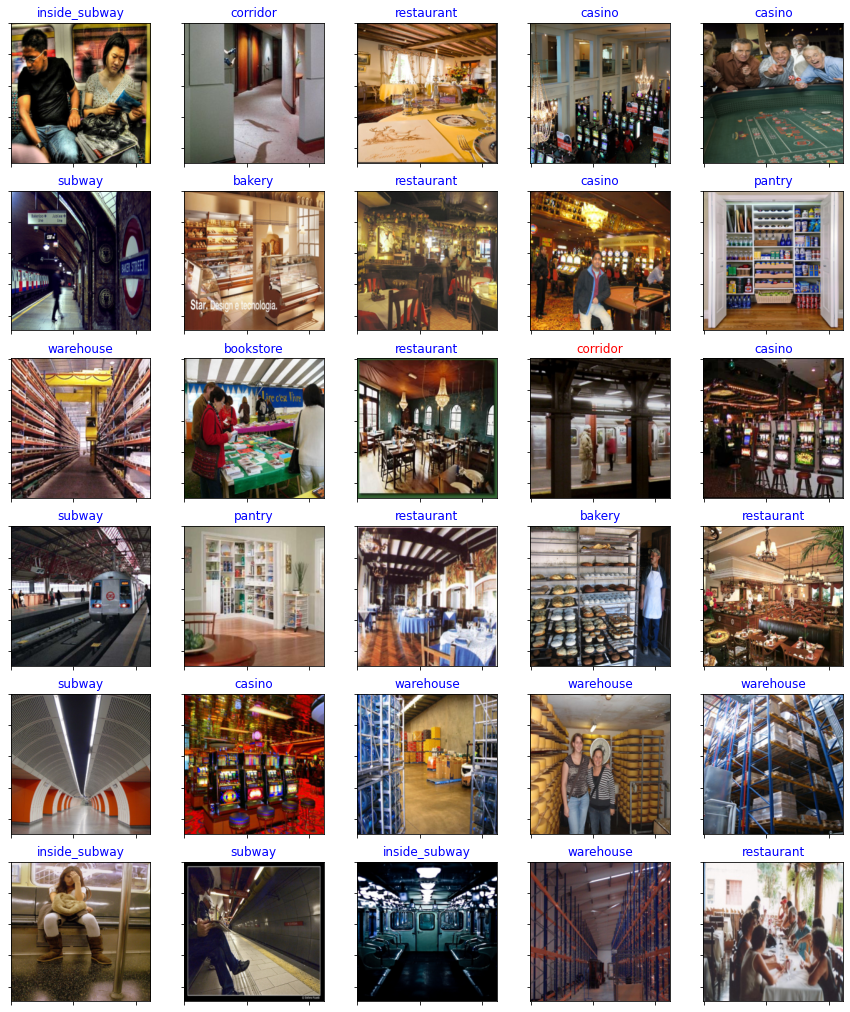

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(6, 5, figsize = (15, 18))
i = 0
for row in range(6):
    ax_row = ax[row]
    for column in range(5):
        ax_column = ax_row[column]
        ax_column.imshow(images[i])
        ax_column.set_xticklabels([])
        ax_column.set_yticklabels([])
        col = 'blue' if labels[i] == predicted[i] else 'red'
        ax_column.set_title(predicted[i], color = col)
        i += 1 